In [1]:
import json
import os
import sys
import argparse
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy import stats
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

src_dir = os.path.abspath(os.path.join(os.pardir, os.pardir,'src'))
sys.path[0] = src_dir
from parser.support import ROLES, CREDITS
from parser.my_mongo_db_login import DB_LOGIN_INFO
import parser.support as support

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
with open('/home/projects/movie-network/data/raw_data/movies.json') as f:
    movie_file = f.read()
    movie_data = json.loads(movie_file)

In [4]:
role = 'producing'
role_key = role + "_gender_percentage"
all_movies = support.get_movies_df(role_key)
print('Got all_movies')


Loaded IMDb movies producing_gender_percentage
Got all_movies


In [5]:
all_movies.columns
#get 90s movies with only producer, id, title, year...
movie_90s = all_movies[(all_movies.year >= 1990) & (all_movies.year < 2000)]
movie_producer_df = movie_90s[['_id', 'producers', 'producing_gender_percentage', 'title', 'year']]

In [6]:
len(movie_90s)

2009

In [9]:
movie_producer_df = movie_producer_df.sort_values('year')

In [11]:
movie_producer_df['producer_num'] = movie_producer_df['producers'].apply(lambda x: len(x))

In [41]:
def unlistify(df, column):
    matches = [i for i,n in enumerate(df.columns)
             if n==column]

    if len(matches)==0:
        raise Exception('Failed to find column named ' + column +'!')
    if len(matches)>1:
        raise Exception('More than one column named ' + column +'!')

    col_idx = matches[0]

    # Helper function to expand and repeat the column col_idx
    def fnc(d):
        row = list(d.values[0])
        bef = row[:col_idx]
        aft = row[col_idx+1:]
        col = row[col_idx]
        z = [bef + [c] + aft for c in col]
        return pd.DataFrame(z)

    col_idx += len(df.index.shape) # Since we will push reset the index
    index_names = list(df.index.names)
    column_names = list(index_names) + list(df.columns)
    return (df
          .reset_index()
          .groupby(level=0,as_index=0)
          .apply(fnc)
          .rename(columns = lambda i :column_names[i])
          .set_index(index_names)
          )

## plot colors

In [29]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return LinearSegmentedColormap.from_list(cmap_name, color_list, N)

viridis_cmap = discrete_cmap(20, 'viridis')


In [35]:
viridis_cmap = cm.viridis.colors

In [37]:
len(viridis_cmap)

256

## Number of producers per movie 

In [13]:
producer_num_list = movie_producer_df.producer_num.tolist()

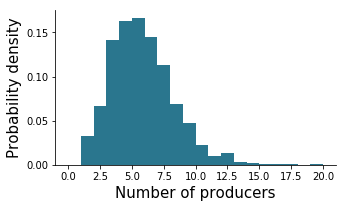

In [40]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(producer_num_list, bins=np.arange(0, max(producer_num_list)+1, 1), color=viridis_cmap[100], density=True)

fontsize=10
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Number of producers', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
plt.savefig('/home/projects/movie-network/result/basic_properties/90s_producers_per_movie.pdf', dpi=300, transparent=True)

## count occurences

### expand the producer column

In [42]:
unlistyfied_producer_df = unlistify(movie_producer_df, 'producers')

In [43]:
unlistyfied_producer_df['producers'] = unlistyfied_producer_df['producers'].apply(lambda x: x[0])

### occurences

In [45]:
occurence_list = unlistyfied_producer_df['producers'].value_counts().values

In [46]:
us = unlistyfied_producer_df['producers'].value_counts()


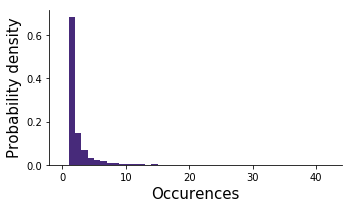

In [50]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(occurence_list, bins=np.arange(0, occurence_list.max(), 1), density=True, color=viridis_cmap[30])
fontsize=10
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Occurences', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
plt.savefig('/home/projects/movie-network/result/90s_producer_movie_occurences.pdf', dpi=300, transparent=True)

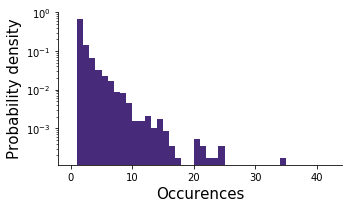

In [51]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(occurence_list, bins=np.arange(0, occurence_list.max(), 1), density=True, color=viridis_cmap[30])
ax.set_yscale('log')
fontsize=10
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Occurences', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
plt.savefig('/home/projects/movie-network/result/90s_producer_movie_occurences_logy.pdf', dpi=300, transparent=True)

## Gap 

In [52]:
gap_list = []
count =0
for p, group in unlistyfied_producer_df.groupby(['producers']):
    group = group.sort_values('year')
    diff = group.year.diff().values
    gap_list.extend(diff[~np.isnan(diff)])

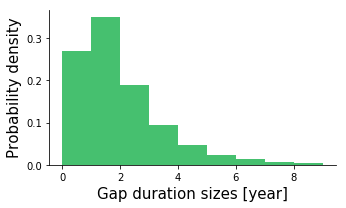

In [54]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(gap_list, bins=np.arange(0, max(gap_list)+1,1), density=True, color=viridis_cmap[180], linestyle='dashed')
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Gap duration sizes [year]', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
plt.savefig('/home/projects/movie-network/result/90s_producer_movie_gaps.pdf', dpi=300, transparent=True)

## Count movies and producers that only appear one time

## Team size dist

In [71]:
producer_num = []
for i, row in movie_producer_df.iterrows():
    producer_num.append(len(row.producers))

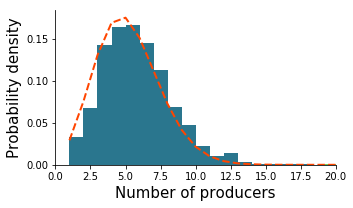

In [81]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(producer_num, bins=np.arange(0, max(producer_num)+1,1), density=True, color=viridis_cmap[200], linestyle='dashed')
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Number of producers', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
# plt.savefig('../result/90s_producer_movie_gaps.pdf', dpi=300, transparent=True)
ax.set_xlim([0,20])

# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(producer_num, bins=np.arange(0, 44, 1), density=True, color=viridis_cmap[100])

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

parameters, cov_matirx = curve_fit(poisson, bin_edges[:-1], entries)

plt.plot(sorted(list(set(producer_num))), poisson(sorted(list(set(producer_num))), *parameters), ls ='--', color='orangered', lw=2)
plt.savefig('/home/projects/movie-network/result/basic_properties/90s_producers_per_movie_poisson_fit.pdf', dpi=300, transparent=True)

In [82]:
producer_test = np.random.poisson(parameters, size=len(producer_num))

In [83]:
stats.ks_2samp(producer_num, producer_test)

Ks_2sampResult(statistic=0.013937282229965153, pvalue=0.9893439010184143)

# Building synthetic networks


* fixed values
    * number of movies per year
    * number of producers per year

* variables
    * number of people per team - producer_num_list
    * number of movies per producer - occurence_list
    * size of gaps - gap_list


In [90]:
number_of_movies_per_year = {}
for year, df in movie_producer_df.groupby('year'):
    number_of_movies_per_year[year] = len(df)

In [91]:
number_of_movies_per_year

{1990: 183,
 1991: 180,
 1992: 202,
 1993: 159,
 1994: 191,
 1995: 194,
 1996: 228,
 1997: 230,
 1998: 209,
 1999: 233}

In [92]:
number_of_producers_per_year = {}
for year, df in unlistyfied_producer_df.groupby('year'):
    number_of_producers_per_year[year] = len(df.producers.unique())

In [93]:
number_of_producers_per_year

{1990: 712,
 1991: 741,
 1992: 843,
 1993: 684,
 1994: 841,
 1995: 930,
 1996: 1101,
 1997: 1169,
 1998: 1113,
 1999: 1232}

In [94]:
for year in number_of_movies_per_year:
    print(year)
    print(number_of_producers_per_year[year]/number_of_movies_per_year[year])

1990
3.890710382513661
1991
4.116666666666666
1992
4.173267326732673
1993
4.30188679245283
1994
4.403141361256544
1995
4.793814432989691
1996
4.828947368421052
1997
5.082608695652174
1998
5.3253588516746415
1999
5.28755364806867
